<a href="https://colab.research.google.com/github/albertofernandezvillan/computer-vision-and-deep-learning-course/blob/main/keras_applications_feature_extraction_for_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" style="padding-right:10px;" src ="https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/university_oviedo_logo.png" width=300 px>

This notebook is from the Course "***Computer vision in the new era of Artificial Intelligence and Deep Learning***", or "*Visión por computador en la nueva era de la Inteligencia Artificial y el Deep Learning*" (ES) from the "Second quarter university extension courses" that the University of Oviedo is offering (05/04/2021 - 16/04/2021)

<[Github Repository](https://github.com/albertofernandezvillan/computer-vision-and-deep-learning-course) | [Course Web Page Information](https://www.uniovi.es/estudios/extension/cursos2c/-/asset_publisher/SEp0PJi4ISGo/content/vision-por-computador-en-la-nueva-era-de-la-inteligencia-artificial-y-el-deep-learning?redirect=%2Festudios%2Fextension%2Fcursos2c)>

# Summary
Keras Applications are deep learning models that are made available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning. In this example, we are going to see how to use them for feature extraction. These features will be used as input to train a [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model. For more information about Keras Applications, see [here](https://keras.io/api/applications/) and [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications). 

At the end of this notebook, you will be creating a binary classifier to classify dog vs cat images training a Logistic Regression model on top of these extracted features. The features used as input to this classifier are going to be generated using a pre-trained [VGG16 model](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16). 

<img align="left" src ="https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/icon_book.png" width=50 px>

*Simonyan, K., & Zisserman, A. (2014). **Very deep convolutional networks for large-scale image recognition**. arXiv preprint arXiv:1409.1556.*

For futher information, you can check other related online resources:

*   [Transfer Learning with Keras and Deep Learning](https://www.pyimagesearch.com/2019/05/20/transfer-learning-with-keras-and-deep-learning/)

*   [Transfer Learning in Keras with Computer Vision Models](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/)

# Download the dataset from Kaggle
We will download a dataset from [Kaggle](https://www.kaggle.com/).
A detail information about how to install kaggle API, configure it and check that it works can be seen in the notebook [set_up_kaggle_api_in_colab.ipynb](https://github.com/albertofernandezvillan/computer-vision-and-deep-learning-course/blob/main/set_up_kaggle_api_in_colab.ipynb) in this [course repository](https://github.com/albertofernandezvillan/computer-vision-and-deep-learning-course)

In [1]:
# Install kaggle API
! pip install kaggle
# Force install the latest version
! pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 4.7MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=d1d65e2c2263b511606fe6359bb0c7de6122c95973b8f28cb5bfba097cf1b021
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [5]:
# Upload 'kaggle.json' file to Colab
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
# Move the uploaded file to a location ~/.kaggle/kaggle.json. 
# Additionally, you need to give proper permissions to the file (since this is a hidden folder). 
# Finally delete the kaggle.json file from the initial location
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! rm kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
# Checking that it works (optional). For example, run the following command:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes        112           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        219           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        702           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       3756           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      30155            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       7880           False  
connectx

Download the cats-dogs dataset from Kaggle and unzip it.

In [8]:
# Download cats-dogs dataset and unzip it:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
!unzip dogs-vs-cats-redux-kernels-edition

 98% 801M/814M [00:07<00:00, 83.1MB/s]
100% 814M/814M [00:07<00:00, 108MB/s] 
Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


We can include `%%capture` magic command to suppress the output.

In [9]:
%%capture
!unzip train.zip -d train
!unzip test.zip -d test

In [10]:
train_dir = '/content/train/train'
test_dir = '/content/test/test'

# Introducing `keras.applications` for feature extraction
We are going to see how to perform feature extraction using [VGG16 model](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16). These features are extracted from a test image included in the repository. The first step is to import the required packages.

In [11]:
# Import required packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

We load the weights from 'imagenet' (pre-trained on ImageNet). Note also `include_top` option: whether to include the 3 fully-connected layers at the top of the network. In this case, these layers are not included. In this specific case, as we will be resizing the images to `(224,224,3)`, we can set the optional parameter `input_shape`.

In [12]:
# Load the model 
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

58892288/58889256 [==============================] - 0s 0us/step


You can explore the loaded model using both `model.summary` and `plot_model` to understand what have been created and loaded.

In [13]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

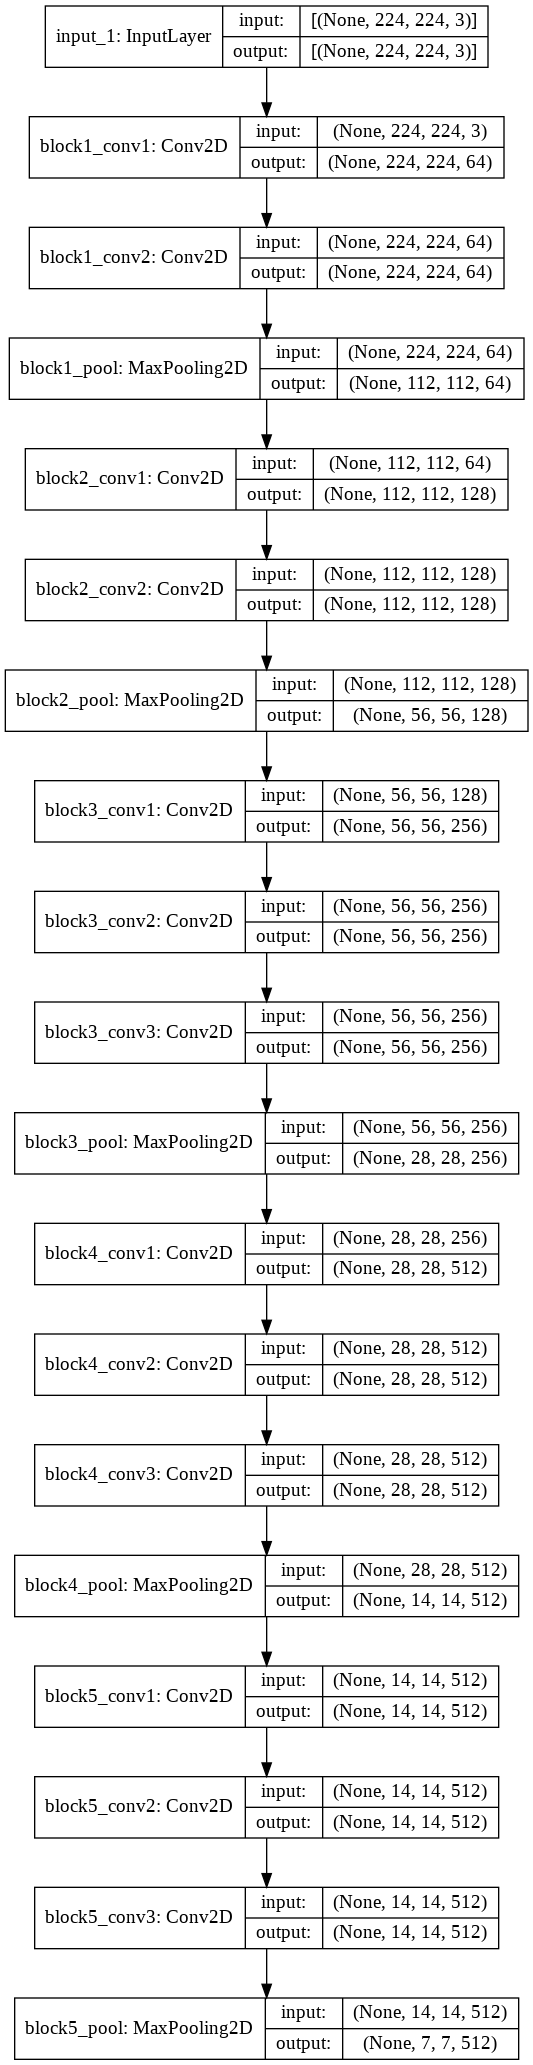

In [14]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='VGG16_without_fc_layers.png', show_shapes=True, show_layer_names=True)

One of the key points to note from the figure above is the output dimension of the max pooling layer: `(batch_size, 7, 7, 512)`. See what happens if we change the value of the parameter `input_shape`.



In [15]:
# Load the model 
model_2 = VGG16(weights="imagenet", include_top=False, input_shape=(112, 112, 3))
model_2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0     

We can see that the output dimension of the max pooling layer is: `(batch_size, 3, 3, 512)`. Therefore, we have seen that if the size of input image changes, the output dimensions of the max pooling layer changes accordingly. Hence, if we use the output of this max pooling layer as a feature extractor, this could lead to feature vectors with different dimensions. In this case, this is not a problem because we will be resizing the images to a unique size (shape). 

In a more general approach, what we can do is to add a global pooling layer. Global pooling is useful when we have a variable size of input images because the shape of the output tensor will be the same.  For example, in connection with the two output shapes we have seen from the max pooling layer (`(batch_size, 7, 7, 512)` and `(batch_size, 3, 3, 512)`), adding a global pooling layer will give us a output tensor of `(batch_size, 512)` in both cases.

From the documentation and in connection with the pooling parameter we can read the following.

`pooling`: Optional pooling mode for feature extraction when `include_top` is `False`:
- `None` means that the output of the model will be the `4D` tensor output of the last convolutional block.
- `avg` means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a `2D` tensor.
- `max` means that global max pooling will be applied, and thus the output of the model will be a `2D` tensor.

Let's check this point.

In [16]:
model_pooling = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3), pooling='max')
model_2_pooling = VGG16(weights="imagenet", include_top=False, input_shape=(112, 112, 3), pooling='max')

print(model_pooling.summary())
print(model_2_pooling.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Overall, we can define the model we will be using for feature extraction. Note also that, as both `input_shape` and `pooling` parameters are optional, our definition of the model could be as follows. To conclude, if we perform `model.summary()` using the instruction defined below, the output shape of the last max pooling layer will be: `(batch_size, None, None, 512)`.

In [17]:
# Load the model 
model = VGG16(weights="imagenet", include_top=False)

We download a test image from the repository. This image will be used later (as an example) to extract the features from it using our feature extractor model:

In [18]:
# Download the image from the repository and rename it to 'sample.png':
!wget https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/lenna.png -O sample.png

--2021-04-10 13:45:53--  https://raw.githubusercontent.com/albertofernandezvillan/computer-vision-and-deep-learning-course/main/assets/lenna.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88235 (86K) [image/png]
Saving to: ‘sample.png’

sample.png          100%[===================>]  86.17K  --.-KB/s    in 0.009s  

2021-04-10 13:45:54 (9.10 MB/s) - ‘sample.png’ saved [88235/88235]



At this point, we can extract the features from the image. We also show the shape of the extracted features:

In [19]:
import numpy as np

image = load_img('/content/sample.png', target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

vgg16_feature = model.predict(image)
# The output dimension of the max-pooling layer is (batch_size, 7, 7, 512)
# In this case, as we are only predicting one image will be (1, 7, 7, 512)
print("Shape of the features: '{}'".format(vgg16_feature.shape))

vgg16_feature_flatten = vgg16_feature.flatten()
print("Shape of the (flatten) features: '{}'".format(vgg16_feature_flatten.shape))

Shape of the features: '(1, 7, 7, 512)'
Shape of the (flatten) features: '(25088,)'


We can see that the loaded image is transformed into a flatten array of shape `(25088,)`. Therefore, we will be using these flatten arrays (one flatten array per image) as the features for our machine learning algorithm. However, before continuing with this point, one more detail to take into account in connection with the previous piece of code. 

We can create a model and include a `tf.keras.layers.Flatten()` layer, which flattens the input.

In [20]:
import tensorflow as tf

# We are going to create a sequential model just to include a flatten layer:
model_flatten = tf.keras.models.Sequential()

# See also the difference between these two lines:
model_flatten.add(VGG16(weights="imagenet", include_top=False))
# model_flatten.add(VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))

model_flatten.add(tf.keras.layers.Flatten())
model_flatten.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, None)              0         
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


We test the output of the `model_flatten` model:

In [21]:
import numpy as np

image = load_img('/content/sample.png', target_size=(224, 224))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

vgg16_feature = model_flatten.predict(image)
# The output dimension is (batch_size, 25088)
# In this case, as we are only predicting one image will be (1, 25088)
print("Shape of the features: '{}'".format(vgg16_feature.shape))

Shape of the features: '(1, 25088)'


At this point, we can continue with our `model` model and create the function `get_features()`, which receives the path of the image and returns the features in the form of a flatten array. See also the included example in order to see how this function works.

In [22]:
# Based on previous inspection, we create a function that receives the path
# of the image and returns the features in the form of a flatten array

import numpy as np

def get_features(path_image):
  img = load_img(path_image, target_size=(224, 224))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)

  vgg16_feats= model.predict(img)
  vgg16_feats_flat = vgg16_feats.flatten()

  return vgg16_feats_flat

# Test this function:
print("Shape of the features: '{}'".format(get_features('/content/sample.png').shape))

Shape of the features: '(25088,)'


# Train the classifier to distinguish between cat and dogs

We are going to train a classifier to distinguish between images containing cats and images containing dogs. To do it, we are going to train a [Logistic Regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Note that we are going to use `N_CATS` and `N_DOGS` images to train this classifier. Further experiments can be added to see the minimum (or the optimal) number of images needed to train this classifier.


What we are going to do next is to extract the features from the first `N_CATS` and `N_DOGS` images included in the `train_dir` directory. All the extracted features are appended to `vgg16_feature_list` structure.

In [23]:
import os

N_CATS = 100
N_DOGS = 100

curr_dogs = 0
curr_cats = 0

vgg16_feature_list = []
labels = []

for filename in os.listdir(train_dir):
  path_image = os.path.join(train_dir, filename)
  class_name = filename.split('.')[0]  

  # check if we have finished extracting features:
  if curr_cats > N_CATS and curr_dogs > N_DOGS:
    print("we are done")
    break

  if "cat" in filename:
    curr_cats += 1
  
  if "dog" in filename:
    curr_dogs += 1
  
  if "cat" in filename and curr_cats > N_CATS:
    continue

  if "dog" in filename and curr_dogs > N_DOGS:
    continue

  print("image {} with class name {}, curr cats: {}, curr dogs: {}".format(filename, class_name, curr_cats, curr_dogs))

  features = get_features(path_image)
  vgg16_feature_list.append(features)
  labels.append(class_name)

image dog.5674.jpg with class name dog, curr cats: 0, curr dogs: 1
image cat.9222.jpg with class name cat, curr cats: 1, curr dogs: 1
image dog.4360.jpg with class name dog, curr cats: 1, curr dogs: 2
image cat.6045.jpg with class name cat, curr cats: 2, curr dogs: 2
image dog.12341.jpg with class name dog, curr cats: 2, curr dogs: 3
image dog.11407.jpg with class name dog, curr cats: 2, curr dogs: 4
image cat.6185.jpg with class name cat, curr cats: 3, curr dogs: 4
image cat.3965.jpg with class name cat, curr cats: 4, curr dogs: 4
image dog.12361.jpg with class name dog, curr cats: 4, curr dogs: 5
image dog.9791.jpg with class name dog, curr cats: 4, curr dogs: 6
image cat.8486.jpg with class name cat, curr cats: 5, curr dogs: 6
image dog.4841.jpg with class name dog, curr cats: 5, curr dogs: 7
image dog.1185.jpg with class name dog, curr cats: 5, curr dogs: 8
image cat.333.jpg with class name cat, curr cats: 6, curr dogs: 8
image cat.3242.jpg with class name cat, curr cats: 7, curr d

At this point, we check the shape of `vgg16_feature_list` taking into account that we have processed a total of (`N_CATS` + `N_DOGS`) images.

In [25]:
vgg16_feature_list_np = np.array(vgg16_feature_list)
print(vgg16_feature_list_np.shape)

labels_np = np.array(labels)
print(labels_np.shape)

(200, 25088)
(200,)


At this point, we are ready to train a [Logistic Regression classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) that will be used to classify the images into two classes (cats and dogs). The code to perform it shown next.

In [26]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression()
log_reg_model.fit(vgg16_feature_list_np, labels_np)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
print(log_reg_model.score(vgg16_feature_list_np, labels_np))

1.0


# Predict the classes of test (new) images

Firts step it to create a function to predict a new image and also to print the predicted label over the image:

In [28]:
from google.colab.patches import cv2_imshow
import cv2

def predict_image(path_image):
  label = log_reg_model.predict(get_features(path_image).reshape(1,-1))[0]

  img = cv2.imread(path_image)
  cv2.putText(img, str(label), (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)

  return img

Just create the path to some test images to see if our classifier is able to predict the correct label:

In [29]:
PATH_TEST_IMG_1 = '/content/test/test/10000.jpg'
PATH_TEST_IMG_2 = '/content/test/test/10001.jpg'
PATH_TEST_IMG_3 = '/content/test/test/10002.jpg'
PATH_TEST_IMG_4 = '/content/test/test/10003.jpg'
PATH_TEST_IMG_5 = '/content/test/test/10004.jpg'
PATH_TEST_IMG_6 = '/content/test/test/10005.jpg'
PATH_TEST_IMG_7 = '/content/test/test/10006.jpg'
PATH_TEST_IMG_8 = '/content/test/test/10007.jpg'
PATH_TEST_IMG_9 = '/content/test/test/10008.jpg'
PATH_TEST_IMG_10 = '/content/test/test/10009.jpg'
PATH_TEST_IMG_11 = '/content/test/test/10010.jpg'
PATH_TEST_IMG_12 = '/content/test/test/10011.jpg'
PATH_TEST_IMG_13 = '/content/test/test/10012.jpg'
PATH_TEST_IMG_14 = '/content/test/test/10013.jpg'
PATH_TEST_IMG_15 = '/content/test/test/10014.jpg'

Finally, call `predict_image()` using the test path images introduced above and also show the resulting image using `cv2_imshow()`:

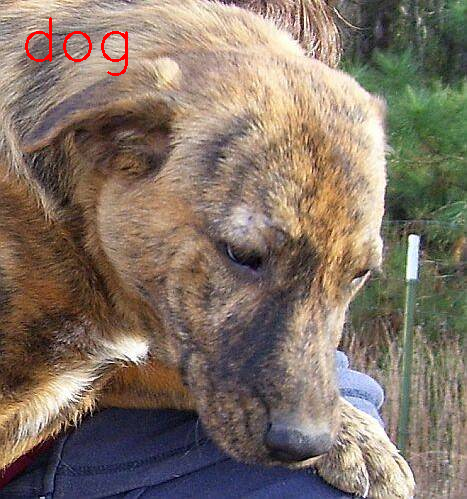

In [30]:
from google.colab.patches import cv2_imshow

cv2_imshow(predict_image(PATH_TEST_IMG_1))

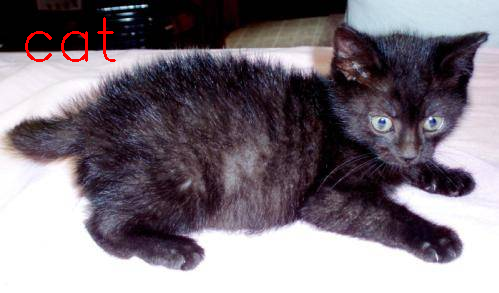

In [31]:
cv2_imshow(predict_image(PATH_TEST_IMG_2))

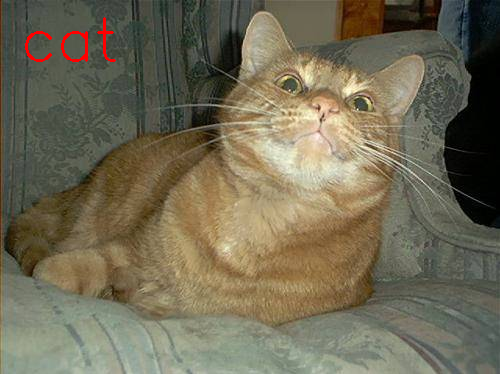

In [32]:
cv2_imshow(predict_image(PATH_TEST_IMG_3))

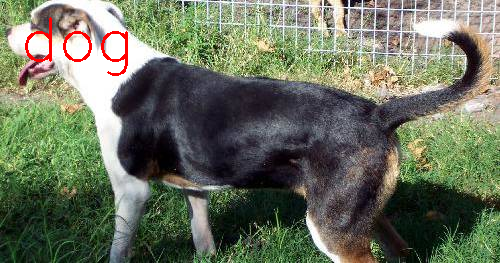

In [33]:
cv2_imshow(predict_image(PATH_TEST_IMG_4))

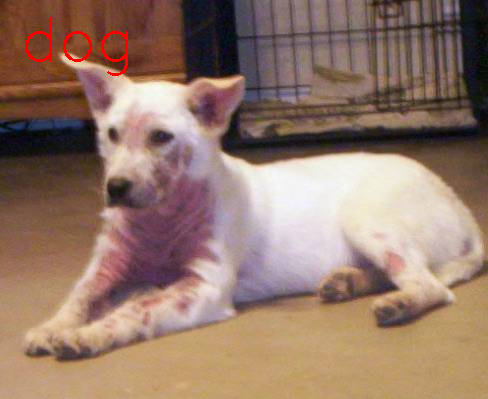

In [34]:
cv2_imshow(predict_image(PATH_TEST_IMG_5))

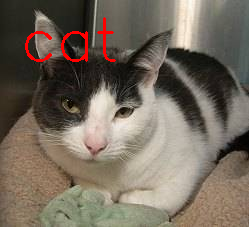

In [35]:
cv2_imshow(predict_image(PATH_TEST_IMG_6))

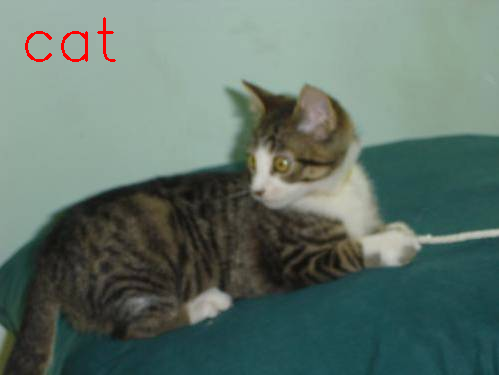

In [36]:
cv2_imshow(predict_image(PATH_TEST_IMG_7))

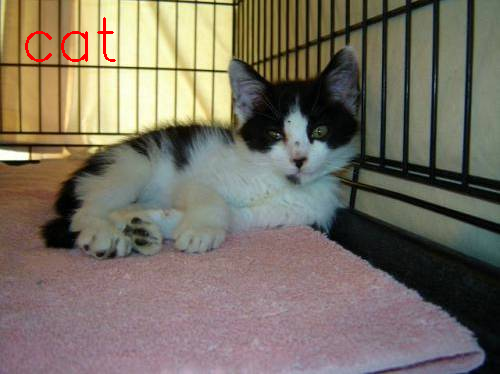

In [37]:
cv2_imshow(predict_image(PATH_TEST_IMG_8))

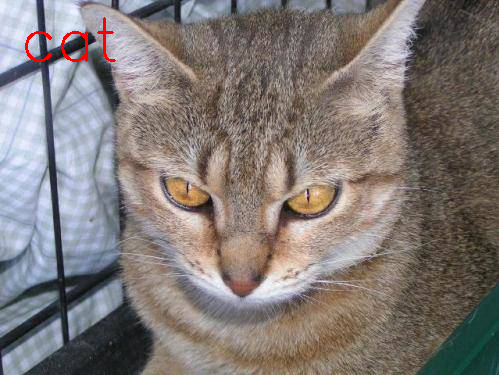

In [38]:
cv2_imshow(predict_image(PATH_TEST_IMG_9))

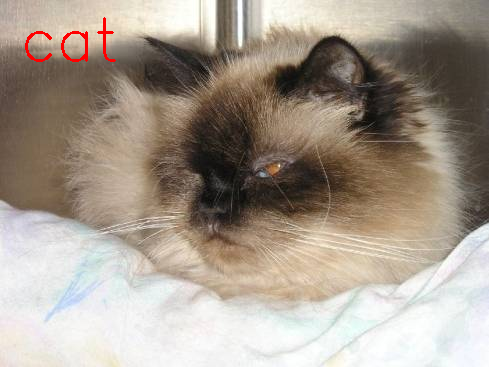

In [39]:
cv2_imshow(predict_image(PATH_TEST_IMG_10))

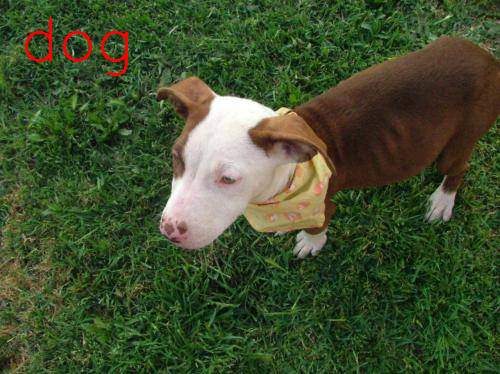

In [40]:
cv2_imshow(predict_image(PATH_TEST_IMG_11))

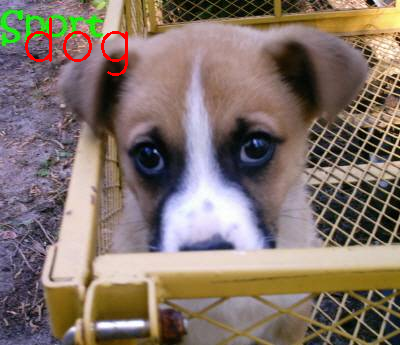

In [41]:
cv2_imshow(predict_image(PATH_TEST_IMG_12))

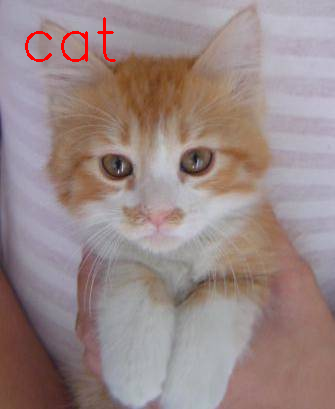

In [42]:
cv2_imshow(predict_image(PATH_TEST_IMG_13))

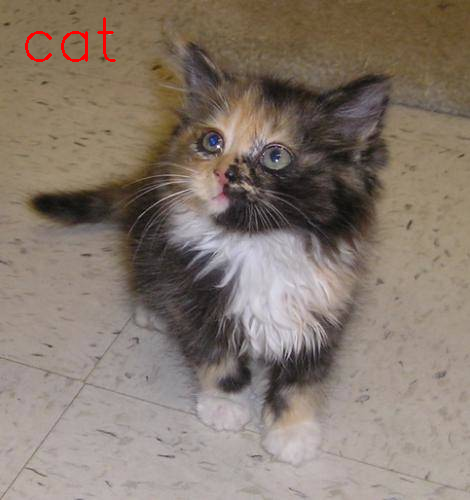

In [43]:
cv2_imshow(predict_image(PATH_TEST_IMG_14))

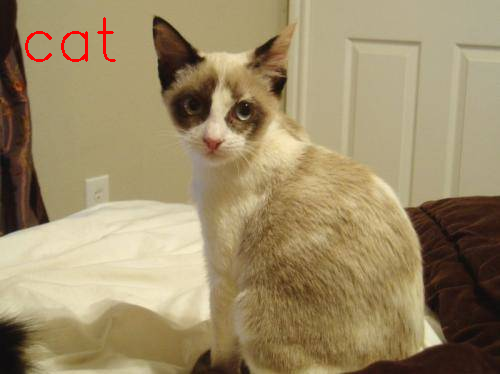

In [44]:
cv2_imshow(predict_image(PATH_TEST_IMG_15))

# Conclusions

In this notebook, we have seen how to use [Keras Applications ](https://keras.io/api/applications/) for feature extraction. In this example we have used the "Dogs vs. Cats Redux: Kernels Edition - Distinguish images of dogs from cats"  dataset from [Kaggle](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition). In this sense, we have download the dataset using the Kaggle API. 

Therefore, we have performed feature extraction using a pre-trained [VGG16 model](https://keras.io/api/applications/vgg/#vgg16-function) using some images of the aforementioned dataset. This (and other models) are pre-trained on ImageNet.  As it is loaded for feature extraction, we have not loaded the weights for the 3 fully-connected layers at the top of the network. These extracted features are used to build a classifier to distinguish between cat and dog images. More specifically, we have trained a Logistic Regression model included in [scikit-learn library](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). 

Finally, we have tested the classifier with some test images (as a simple "validation").